In [1]:
# load the data from the uproot files
import uproot
import warnings
import numpy as np
import numba
import awkward as ak
import vector
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory

NanoAODSchema.warn_missing_crossrefs = False
warnings.filterwarnings("ignore", category=FutureWarning, module="coffea.*")
vector.register_awkward()

In [15]:
def solve_neutrino_pz(lepton, met, mW=80.4):
    """
    Compute neutrino pz solutions from lepton and MET using W mass constraint.

    Parameters
    ----------
    lepton : ak.Array
        Lepton 4-vector (pt, eta, phi, mass).
    met : ak.Array
        MET as a 4-vector (pt, phi); eta=0, mass=0.

    Returns
    -------
    ak.Array
        Array of shape (n_events, 2) with pz solutions (real or complex).
        If no real solution, return real part of complex root.
    """
    px_l = lepton.pt * np.cos(lepton.phi)
    py_l = lepton.pt * np.sin(lepton.phi)
    pz_l = lepton.pz
    e_l = lepton.energy

    px_nu = met.pt * np.cos(met.phi)
    py_nu = met.pt * np.sin(met.phi)

    pt_l_sq = lepton.pt ** 2
    pt_nu_sq = met.pt ** 2

    # mu = (mW^2 / 2) + px_l * px_nu + py_l * py_nu
    mu = (mW**2) / 2 + px_l * px_nu + py_l * py_nu

    a = mu * pz_l / pt_l_sq
    A = (mu ** 2) * (pz_l ** 2)
    B = (e_l ** 2) * (pt_l_sq * pt_nu_sq)
    C = (mu ** 2) * pt_l_sq
    discriminant = A - B + C

    print(discriminant)
    sqrt_discriminant = ak.where(discriminant >= 0,
                                  np.sqrt(discriminant),
                                  np.sqrt(-discriminant) * 1j)
    pz_nu_1 = a + sqrt_discriminant / pt_l_sq
    pz_nu_2 = a - sqrt_discriminant / pt_l_sq

    return pz_nu_1, pz_nu_2

def build_leptonic_tops(muon, met, lepjet, pz1, pz2):
    """
    Return list of leptonic top 4-vectors per event based on neutrino pz solutions.
    """
    # ============================================================
    # Solve for neutrino
    # ============================================================
    def make_nu(pz):
        return ak.zip({
            "pt": met.pt,
            "phi": met.phi,
            "eta": ak.zeros_like(met.pt),
            "mass": ak.zeros_like(met.pt),
            "pz": ak.real(pz),
        }, with_name="Momentum4D")

    def ak_is_real(array):
        return ak.real(array) == array

    pz1 = ak.Array(pz1)
    pz2 = ak.Array(pz2)

    # Count real solutions
    disc = (pz1 - pz2) ** 2
    two_real = ak_is_real(pz1) & (disc != 0)
    one_real = ak_is_real(pz1) & (disc == 0)
    no_real = ~ak_is_real(pz1)

    # Always build all 3 cases per element — rely on masking
    nu1 = make_nu(pz1)
    nu2 = make_nu(pz2)

    lep_top1 = muon + lepjet + nu1
    lep_top2 = muon + lepjet + nu2

    lep_top1_masked_two = ak.mask(lep_top1, two_real)
    lep_top2_masked_two = ak.mask(lep_top2, two_real)

    lep_top_candidates = ak.where(
        ak.firsts(two_real, axis=1),
        ak.concatenate([lep_top1_masked_two, lep_top2_masked_two], axis=1),
        lep_top1
    )
    lep_top_candidates = ak.zip(
        {
            "pt": lep_top_candidates.pt,
            "eta": lep_top_candidates.eta,
            "phi": lep_top_candidates.phi,
            "mass": lep_top_candidates.mass,
        },
        with_name="Momentum4D"
    )
    return lep_top_candidates


@numba.njit
def build_index(index_values, a_lengths, b_offsets):
    """
    Fill `index_values` such that for each sublist in `a`, we repeat the elements
    from the corresponding sublist in `b` cyclically to match its length.

    Parameters
    ----------
    index_values : np.ndarray
        Output array to fill with indices into flattened `b`.
    a_lengths : np.ndarray
        Length of each sublist in `a`.
    b_offsets : np.ndarray
        Offsets defining the start/stop positions of each sublist in `b`.
    """
    pos = 0
    for i in range(len(a_lengths)):
        len_a_i = a_lengths[i]               # number of entries in a[i]
        start_b_i = b_offsets[i]             # start of b[i] in flat_b
        stop_b_i = b_offsets[i + 1]          # end of b[i]
        len_b_i = stop_b_i - start_b_i       # number of entries in b[i]

        if len_b_i == 0:
            if len_a_i != 0:
                raise ValueError(f"Incompatible: a[{i}] has length {len_a_i} "
                                 f"but b[{i}] is empty.")
            continue  # skip if both are empty

        # Repeat b[i] cyclically to fill a[i]
        for j in range(len_a_i):
            index_values[pos] = start_b_i + (j % len_b_i)
            pos += 1

def map_a_to_b(a: ak.Array, b: ak.Array) -> ak.Array:
    """
    Map the jagged structure of `a` onto `b`, such that each sublist in `a` gets
    a matching sublist from `b`, repeating elements cyclically if needed.

    Parameters
    ----------
    a : ak.Array
        Jagged array whose structure will be imposed.
    b : ak.Array
        Jagged array to be aligned with `a`.

    Returns
    -------
    ak.Array
        Jagged array with the same outer structure as `a`, filled with elements from `b`.
    """
    # Ensure inputs are Awkward Arrays
    a = ak.Array(a)
    b = ak.Array(b)

    # Flatten b and get its list offsets
    flat_b = ak.flatten(b)
    b_offsets = b.layout.offsets.data

    # Get offsets and lengths of sublists in `a`
    a_offsets = a.layout.offsets.data
    a_lengths = a_offsets[1:] - a_offsets[:-1]

    # Allocate index array that will map a -> b
    index_values = np.empty(a_offsets[-1], dtype=np.int64)

    # Fill the index array using the numba-accelerated function
    build_index(index_values, a_lengths, b_offsets)

    # Build the Awkward IndexedArray from the flat content of b
    index = ak.index.Index64(index_values)
    indexed_array = ak.contents.IndexedArray(index, flat_b.layout)

    # Wrap into a jagged array with the same offsets as a
    list_array = ak.contents.ListOffsetArray(a.layout.offsets, indexed_array)
    return ak.Array(list_array)


def ttbar_reco(
    muons: ak.Array,
    jets: ak.Array,
    fatjets: ak.Array,
    met: ak.Array,
) -> tuple[ak.Array, ak.Array]:
    """
    Perform semi-leptonic ttbar reconstruction using fatjets if available,
    falling back to combinatoric jet assignment otherwise.

    Parameters
    ----------
    muons : ak.Array
        Array of muon candidates.
    jets : ak.Array
        Array of jet candidates.
    fatjets : ak.Array
        Array of fatjet candidates.
    met : ak.Array
        Array of MET information.

    Returns
    -------
    tuple[ak.Array, ak.Array]
        Tuple of (chi2, mtt) values for the best ttbar reconstruction per event.
    """
    # Define Gaussian means and widths for chi2 computation
    mean_mlep = 175.
    sigma_mlep = 19.
    mean_mhad_fj = 173.
    sigma_mhad_fj = 15.
    mean_mhad_nofj = 177.
    sigma_mhad_nofj = 16.

    # Define which events have at least one fatjet
    has_fatjet = ak.num(fatjets, axis=1) > 0
    no_fatjet = ~has_fatjet

    # ============================================================
    # Fatjet-based reconstruction
    # ============================================================

    # Mask inputs to only fatjet-containing events
    fatjets_masked = ak.mask(fatjets, has_fatjet)
    jets_masked = ak.mask(jets, has_fatjet)
    muons_masked = ak.mask(muons, has_fatjet)
    met_masked = ak.mask(met, has_fatjet)

    # Use leading fatjet as hadronic top candidate
    leading_fatjet = fatjets_masked[:, 0]
    had_top_fj = ak.zip(
        {
            "pt": leading_fatjet.pt,
            "eta": leading_fatjet.eta,
            "phi": leading_fatjet.phi,
            "mass": leading_fatjet.mass,
        },
        with_name="Momentum4D",
    )
    # Use leading muon
    leading_muon = muons_masked[:, 0]

    # Broadcast other objects to jet axis
    fatjet_broadcast = ak.broadcast_arrays(jets_masked, leading_fatjet)[1]
    muon_broadcast = ak.broadcast_arrays(jets_masked, leading_muon)[1]
    met_broadcast = ak.broadcast_arrays(jets_masked, met_masked)[1]

    # Reject jets too close to fatjet (likely overlap with substructure)
    delta_r = jets_masked.deltaR(fatjet_broadcast)
    jet_mask = delta_r > 1.2

    valid_jets = jets_masked[jet_mask]
    valid_muons = muon_broadcast[jet_mask]
    valid_met = met_broadcast[jet_mask]

    # Construct 4-vectors for leptonic top components
    valid_muons_4vec, valid_jets_4vec = [
        ak.zip(
            {"pt": obj.pt, "eta": obj.eta, "phi": obj.phi, "mass": obj.mass},
            with_name="Momentum4D",
        )
        for obj in [valid_muons, valid_jets]
    ]
    valid_met_4vec = ak.zip(
        {
            "pt": valid_met.pt,
            "eta": 0 * valid_met.pt,
            "phi": valid_met.phi,
            "mass": 0,
        },
        with_name="Momentum4D",
    )

    # Leptonic top: muon + MET + jet
    #lep_top_fj = valid_muons_4vec + valid_met_4vec + valid_jets_4vec
    # Solve for neutrino
    pz1_fj, pz2_fj = solve_neutrino_pz(valid_muons_4vec, valid_met_4vec)
    lep_top_fj = build_leptonic_tops(valid_muons_4vec, valid_met_4vec, valid_jets_4vec, pz1_fj, pz2_fj)

    had_mass_broadcast = ak.broadcast_arrays(lep_top_fj, had_top_fj)[1].mass

    # Chi² for each combination
    chi2_fj = ((lep_top_fj.mass - mean_mlep) / sigma_mlep) ** 2 + (
        (had_mass_broadcast - mean_mhad_fj) / sigma_mhad_fj
    ) ** 2

    # ============================================================
    # Combinatoric AK4 reconstruction (no fatjets)
    # ============================================================

    jets_nofj = ak.mask(jets, no_fatjet)
    muons_nofj = ak.mask(muons, no_fatjet)[:, 0]
    met_nofj = ak.mask(met, no_fatjet)

    # All jet pairs -> one jet for leptonic top, two for hadronic top
    # combs = ak.combinations(jets_nofj, 2, axis=1, replacement=False)
    # lepjet, hadjets = combs["0"], combs["1"]
    four_jet_combos = ak.combinations(jets, 4, fields=["j1", "j2", "j3", "j4"])  # trijet candidates
    lepjet = four_jet_combos["j4"]
    had_top_nofj = four_jet_combos["j1"] + four_jet_combos["j2"] + four_jet_combos["j3"]
    hadjets = ak.concatenate([four_jet_combos["j1"], four_jet_combos["j2"], four_jet_combos["j3"]], axis=1)

    # Broadcast muon and MET to pair structure
    muon_broadcast = ak.broadcast_arrays(lepjet, muons_nofj)[1]
    met_broadcast = ak.broadcast_arrays(lepjet, met_nofj)[1]

    # Leptonic top 4-vectors
    lepjet_4vec = ak.zip(
        {
            "pt": lepjet.pt,
            "eta": lepjet.eta,
            "phi": lepjet.phi,
            "mass": lepjet.mass,
        },
        with_name="Momentum4D",
    )
    muon_4vec = ak.zip(
        {
            "pt": muon_broadcast.pt,
            "eta": muon_broadcast.eta,
            "phi": muon_broadcast.phi,
            "mass": muon_broadcast.mass,
        },
        with_name="Momentum4D",
    )
    met_4vec = ak.zip(
        {
            "pt": met_broadcast.pt,
            "eta": 0 * met_broadcast.pt,
            "phi": met_broadcast.phi,
            "mass": 0,
        },
        with_name="Momentum4D",
    )

    pz1_nofj, pz2_nofj = solve_neutrino_pz(muon_4vec, met_4vec)
    lep_top_nofj = build_leptonic_tops(muon_4vec, met_4vec, lepjet_4vec, pz1_nofj, pz2_nofj)

    # Hadronic top = dijet system
    hadjets_4vec = ak.zip(
        {
            "pt": hadjets.pt,
            "eta": hadjets.eta,
            "phi": hadjets.phi,
            "mass": hadjets.mass,
        },
        with_name="Momentum4D",
    )
    had_top_nofj_2 = ak.sum(hadjets_4vec, axis=1)
    had_top_nofj = ak.zip(
        {
            "pt": had_top_nofj.pt,
            "eta": had_top_nofj.eta,
            "phi": had_top_nofj.phi,
            "mass": had_top_nofj.mass,
        },
        with_name="Momentum4D",
    )

    # Map leptonic top jagged structure onto hadronic tops
    had_top_nofj = map_a_to_b(lep_top_nofj, had_top_nofj)

    # Make sure if we don't have a leptonic top, we don't have a hadronic top
    lep_empty = ak.num(lep_top_nofj, axis=1) == 0
    had_top_nofj = ak.where(lep_empty, ak.Array([[]] * len(lep_top_nofj)), had_top_nofj)

    # Chi² for each combination
    chi2_nofj = ((lep_top_nofj.mass - mean_mlep) / sigma_mlep) ** 2 + (
        (had_top_nofj.mass - mean_mhad_nofj) / sigma_mhad_nofj
    ) ** 2

    # ============================================================
    # Select best candidate and compute mtt
    # ============================================================
    best_idx_fj = ak.argmin(chi2_fj, axis=1, keepdims=True)
    best_idx_nofj = ak.argmin(chi2_nofj, axis=1, keepdims=True)

    # Use chi2 to select best pairing
    lep_top_fj_best = lep_top_fj[best_idx_fj]
    had_top_fj_best = ak.broadcast_arrays(lep_top_fj, had_top_fj)[1][
        best_idx_fj
    ]

    lep_top_nofj_best = lep_top_nofj[best_idx_nofj]
    had_top_nofj_best = ak.broadcast_arrays(lep_top_nofj, had_top_nofj)[1][
        best_idx_nofj
    ]

    # Choose reconstruction based on presence of fatjet
    lep_top = ak.flatten(
        ak.where(has_fatjet, lep_top_fj_best, lep_top_nofj_best)
    )
    had_top = ak.flatten(
        ak.where(has_fatjet, had_top_fj_best, had_top_nofj_best)
    )
    mtt = ak.fill_none((lep_top + had_top).mass, -1.0)

    # Final chi2 score
    chi2 = ak.where(has_fatjet, chi2_fj, chi2_nofj)
    best_idx = ak.argmin(chi2, axis=1, keepdims=True)
    best_chi2 = ak.fill_none(ak.flatten(chi2[best_idx]), 9999.0)

    return best_chi2, mtt

In [94]:
# variables into memory (takes ~1min)
file_dict = {
    "wjets": "preproc_uproot/z-prime-ttbar-data/signal__nominal/file__0/part0.root",
    "ttbar_had": "preproc_uproot/z-prime-ttbar-data/ttbar_had__nominal/file__0/part0.root",
    "ttbar_lep": "preproc_uproot/z-prime-ttbar-data/ttbar_lep__nominal/file__0/part0.root",
    "ttbar_semilep": "preproc_uproot/z-prime-ttbar-data/ttbar_semilep__nominal/file__0/part0.root",
}

data = {}
for proc, file_path in file_dict.items():
    print(f"Processing {proc}...")
    data[proc] = {}
    events = NanoEventsFactory.from_root(
        f"{file_path}:Events", schemaclass=NanoAODSchema, delayed=False,
    ).events()

    print(events.Jet.fields)

    jets, muons = events.Jet, events.Muon

    muons = muons[
        (muons.pt > 55)
        & (abs(muons.eta) < 2.4)
        & muons.tightId
        & (muons.miniIsoId > 1)
    ]
    jets = jets[
        (jets.pt > 30)
        & (abs(jets.eta) < 2.4)
        & jets.isTightLeptonVeto
        #& (jets.jetId >= 4)
    ]

    # require at least 2 jets and exaclty 1 muon
    mask = (ak.num(jets, axis=1) >= 2) & (ak.num(muons, axis=1) == 1)
    muons = muons[mask]
    jets = jets[mask]
    fatjet = events.FatJet[mask]
    met = events.PuppiMET[mask]

    _, mtt = ttbar_reco(
        muons,
        jets,
        fatjet,
        met,)
    mtt = mtt.to_numpy()
    # number of jets
    data[proc]["n_jet"] = ak.num(jets, axis=1).to_numpy()

    # leading and subleading jet mass
    data[proc]["leading_jet_mass"] = jets.mass[:, 0].to_numpy()/mtt
    data[proc]["subleading_jet_mass"] = jets.mass[:, 1].to_numpy()/mtt

    # leading and subleading jet pt
    data[proc]["leading_jet_pt"] = jets.pt[:, 0].to_numpy()/mtt
    data[proc]["subleading_jet_pt"] = jets.pt[:, 1].to_numpy()/mtt

    # leading and subleading jet eta
    data[proc]["leading_jet_eta"] = jets.eta[:, 0].to_numpy()
    data[proc]["subleading_jet_eta"] = jets.eta[:, 1].to_numpy()

    # leading and subleading jet eta
    data[proc]["leading_jet_phi"] = jets.phi[:, 0].to_numpy()
    data[proc]["subleading_jet_phi"] = jets.phi[:, 1].to_numpy()

    # leading and subleading jet eta
    data[proc]["muon_pt"] = jets.pt[:, 0].to_numpy()/mtt
    data[proc]["muon_eta"] = jets.eta[:, 1].to_numpy()
    data[proc]["muon_phi"] = jets.phi[:, 1].to_numpy()

    # scalar sum ST
    data[proc]["st"] = (
        ak.sum(jets.pt, axis=1) + ak.sum(muons.pt, axis=1)
    ).to_numpy()/mtt

    # leading and subleading jet b-tag score
    data[proc]["leading_jet_btag_score"] = jets.btagDeepB[:, 0].to_numpy()
    data[proc]["subleading_jet_btag_score"] = jets.btagDeepB[:, 1].to_numpy()

    # Sphericity tensor (only zz component)
    denominator = ak.sum(jets.px**2 + jets.py**2 + jets.pz**2, axis=1)
    S_zz = ak.sum(jets.pz * jets.pz, axis=1) / denominator
    data[proc]["S_zz"] = S_zz.to_numpy()

    # deltaR between muon and closest jet
    muon_in_pair, jet_in_pair = ak.unzip(ak.cartesian([muons, jets]))
    delta_r = muon_in_pair.deltaR(jet_in_pair)
    min_delta_r = ak.min(delta_r, axis=1)
    data[proc]["deltaR"] = min_delta_r.to_numpy()

    # transverse momentum of the muon w.r.t. the axis of the nearest jet (pt_rel)
    min_delta_r_indices = ak.argmin(delta_r, axis=1, keepdims=True)
    angle = muons.deltaangle(jet_in_pair[min_delta_r_indices])
    data[proc]["pt_rel"] = (muons.p * np.sin(angle)).to_numpy().flatten()/mtt

    # deltaR between muon and closest jet times the jet pt
    min_delta_r_indices = ak.argmin(delta_r, axis=1, keepdims=True)
    closest_jet_pt = jet_in_pair.pt[min_delta_r_indices]
    data[proc]["deltaR_times_pt"] = (min_delta_r * closest_jet_pt).to_numpy().flatten()/mtt

for proc, dd in data.items():
    for var, vals in dd.items():
        print(f"{var} mean:: ", ak.mean(vals))

'''
n_jet mean::  4.3891362634118
leading_jet_mass mean::  10.055629503340747
subleading_jet_mass mean::  7.453458137087288
st mean::  291.79430715819854
leading_jet_btag_score mean::  -0.151603204560012
subleading_jet_btag_score mean::  -0.29117383163160826
S_zz mean::  0.8446572907092479
deltaR mean::  0.012122709877853207
pt_rel mean::  0.7693565520780253
deltaR_times_pt mean::  0.932584646733307
'''

Processing wjets...
['btagDeepB', 'jetId', 'pt', 'eta', 'phi', 'mass']
[[-2.1e+12], [4.42e+13], ..., [...], [4.45e+13, 4.45e+13, 4.45e+13, 4.45e+13]]


/Users/moaly/miniforge3/envs/lino_zprime_jax/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


[None, None, None, None, None, None, ..., None, None, None, None, None, None]
Processing ttbar_had...
['btagDeepB', 'jetId', 'pt', 'eta', 'phi', 'mass']
[None, None, [1.43e+11, ...], ..., [...], None, [1.46e+11, 1.46e+11, 1.46e+11]]
[[2.76e+11, 2.76e+11, 2.76e+11, ..., 2.76e+11, 2.76e+11, 2.76e+11], ..., None]
Processing ttbar_lep...
['btagDeepB', 'jetId', 'pt', 'eta', 'phi', 'mass']
[[2.03e+12, 2.03e+12], None, None, None, ..., [1.22e+12, ...], None, None, None]
[None, [], [], [-3.64e+12, -3.64e+12, ..., -3.64e+12], ..., None, [], [], []]
Processing ttbar_semilep...
['btagDeepB', 'jetId', 'pt', 'eta', 'phi', 'mass']
[[1.61e+11, 1.61e+11, 1.61e+11, 1.61e+11], [9.14e+11], [...], ..., None, None]
[None, None, None, None, ..., [9.8e+11, ..., 9.8e+11], [1.92e+11], [1.82e+11]]
n_jet mean::  4.093265339161405
leading_jet_mass mean::  -1.0360219777912103
subleading_jet_mass mean::  -0.23088910144250507
leading_jet_pt mean::  -7.5942358542409165
subleading_jet_pt mean::  -1.8177690793247074
le

'\nn_jet mean::  4.3891362634118\nleading_jet_mass mean::  10.055629503340747\nsubleading_jet_mass mean::  7.453458137087288\nst mean::  291.79430715819854\nleading_jet_btag_score mean::  -0.151603204560012\nsubleading_jet_btag_score mean::  -0.29117383163160826\nS_zz mean::  0.8446572907092479\ndeltaR mean::  0.012122709877853207\npt_rel mean::  0.7693565520780253\ndeltaR_times_pt mean::  0.932584646733307\n'

In [95]:
cd6 = {
    "blue": "#5790fc",
    "orange": "#f89c20",
    "red": "#e42536",
    "violet": "#964a8b",
    "gray": "#9c9ca1",
    "purple": "#7a21dd",
}

process_color_dict = {
    "wjets": cd6["blue"],
    "ttbar_had": cd6["red"],
    "ttbar_lep": cd6["orange"],
    "ttbar_semilep": cd6["purple"],
    "ttbar": cd6["red"],
}

model_color_dict = {}

In [96]:
processes = list(data.keys())
variables = list(data[processes[0]].keys())

data["ttbar"] = {}
for var in variables:
    data["ttbar"][var] = np.concatenate([data[p][var] for p in ["ttbar_had", "ttbar_lep", "ttbar_semilep"]])

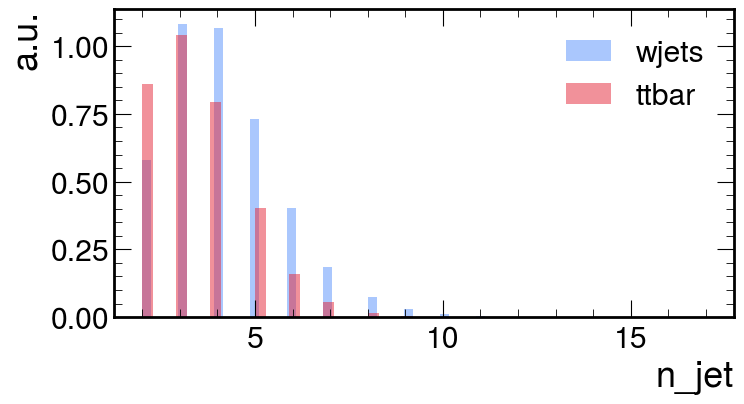

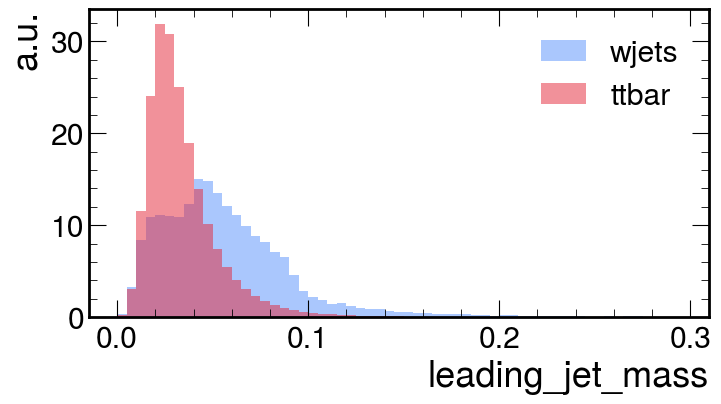

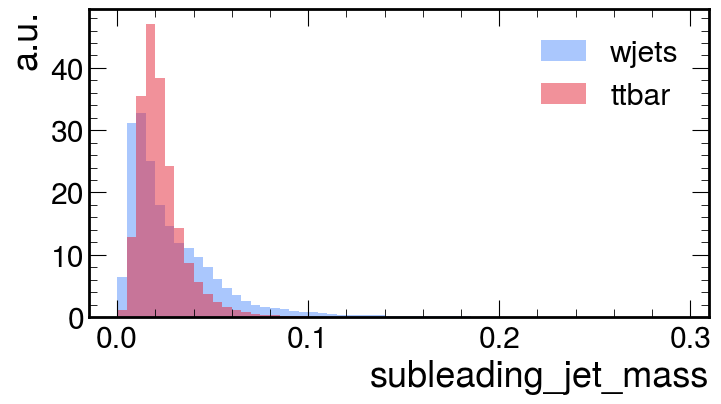

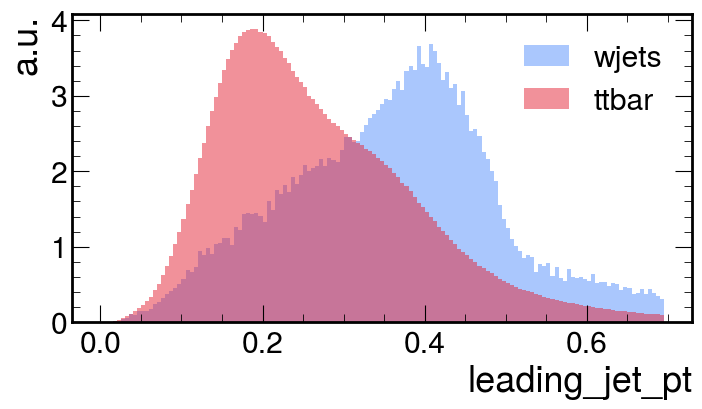

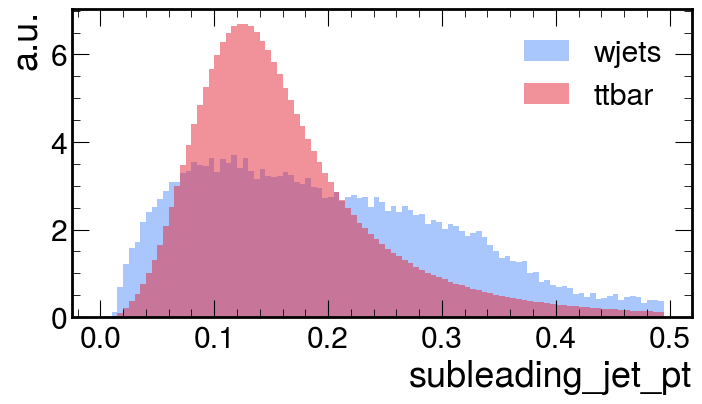

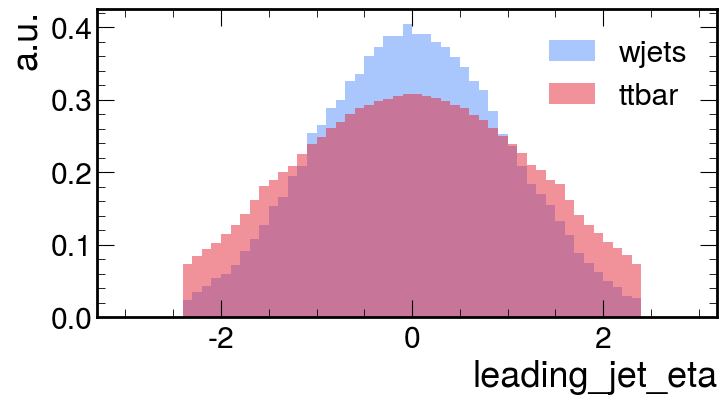

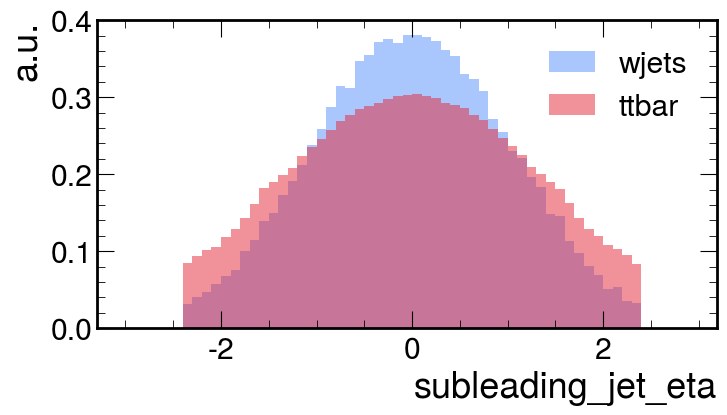

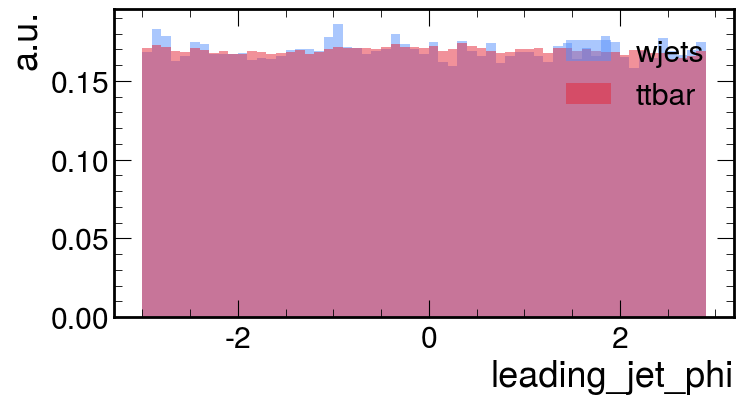

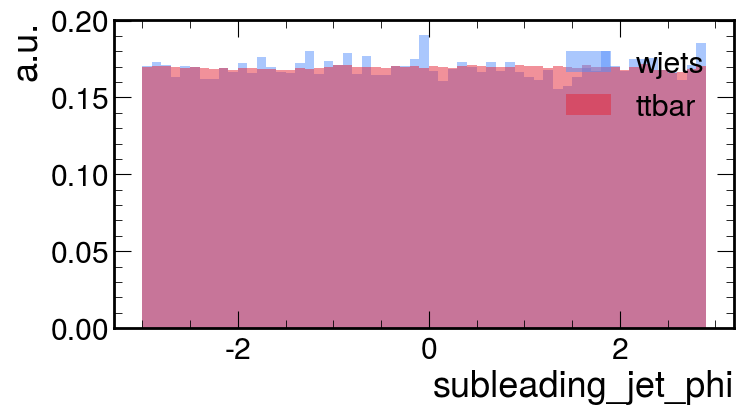

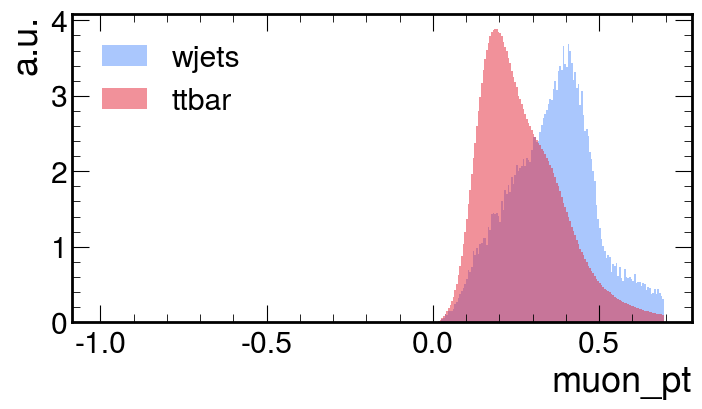

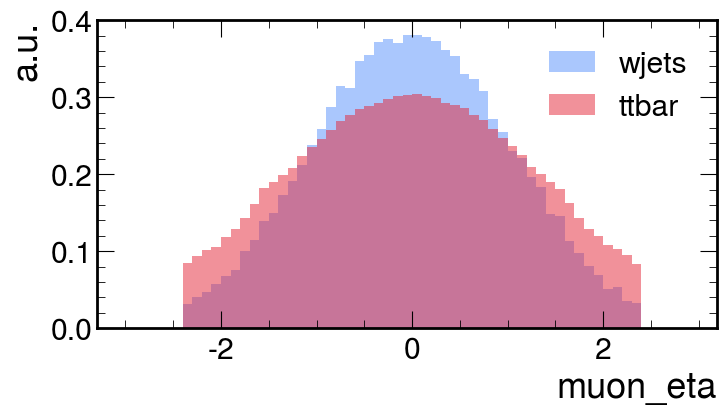

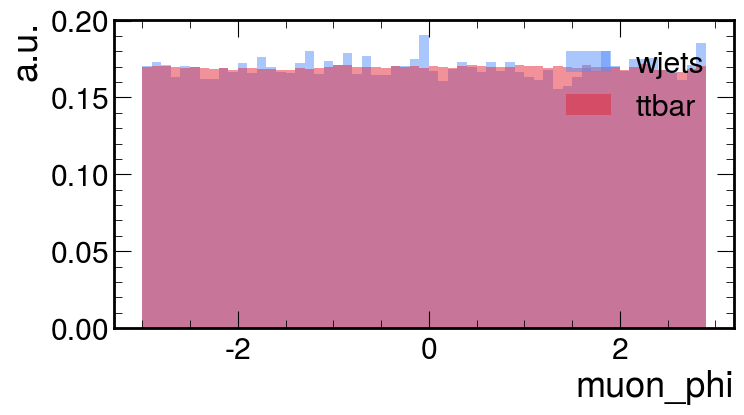

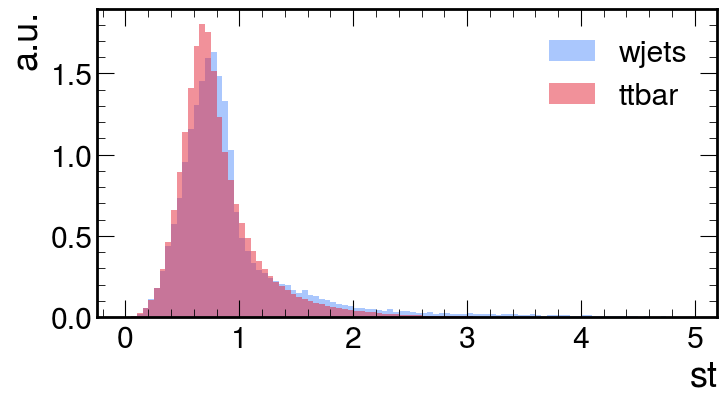

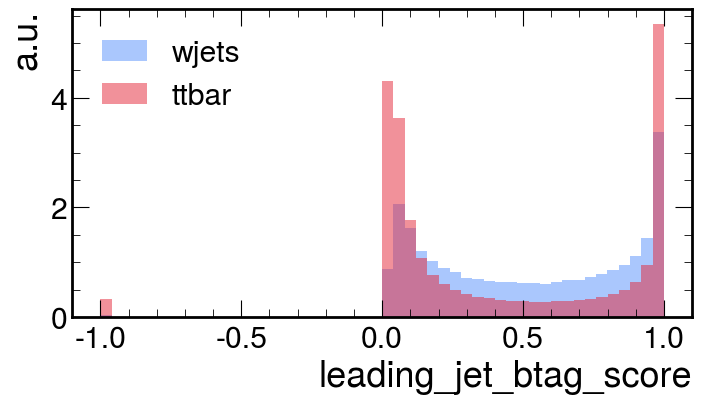

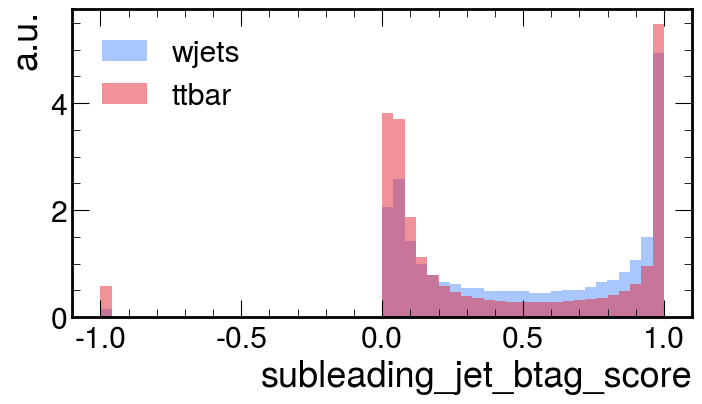

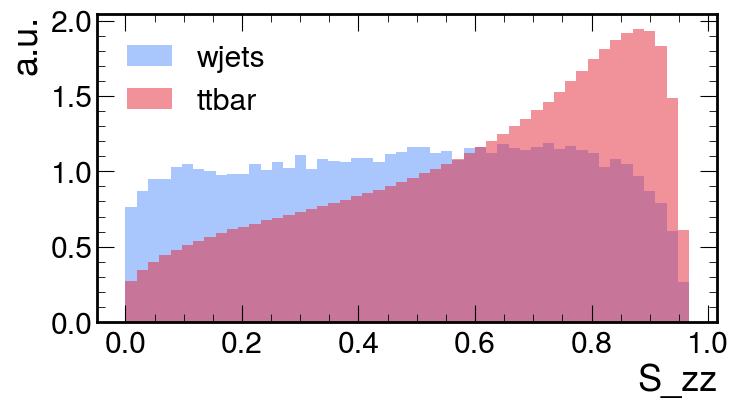

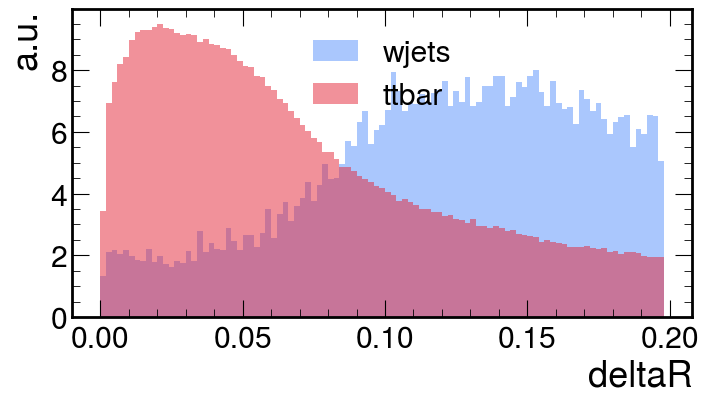

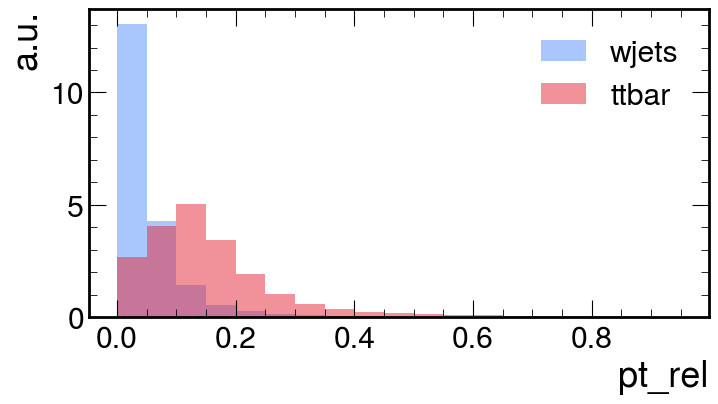

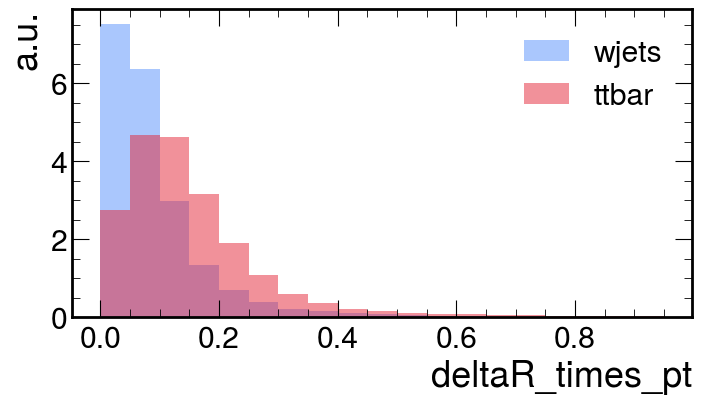

In [ ]:
import importlib
from utils import drawing
importlib.reload(drawing)
draw = drawing.Draw(output_dir="output/plots/", interactive=True)
draw.process_color_dict = process_color_dict

binnings = {
    "n_jet": 50,
    "leading_jet_mass": np.arange(0, 0.3, 0.005),
    "subleading_jet_mass": np.arange(0, 0.3, 0.005),
    "leading_jet_pt": np.arange(0, 0.7, 0.005),
    "subleading_jet_pt": np.arange(0, 0.5, 0.005),
    "leading_jet_eta": np.arange(-3.0, 3.0, 0.1),
    "subleading_jet_eta": np.arange(-3.0, 3.0, 0.1),
    "leading_jet_phi": np.arange(-3.0, 7.0, 0.1),
    "subleading_jet_phi": np.arange(-3.0, 7.0, 0.1),
    "muon_pt": np.arange(-1, 0.7, 0.005),
    "muon_eta": np.arange(-3.0, 3.0, 0.1),
    "muon_phi": np.arange(-3.0, 3.0, 0.1),
    "st": np.arange(0, 5, 0.05),
    "leading_jet_btag_score": 50,
    "subleading_jet_btag_score": 50,
    "S_zz": 50,
    "deltaR": np.arange(0, 0.2, 0.002),
    "pt_rel": np.arange(0, 1, 0.05),
    "deltaR_times_pt": np.arange(0, 1, 0.05),
}

for var, bins in binnings.items():
    draw.plot_simple_hist(
        {p: data[p][var] for p in ["wjets", "ttbar"]},
        bins=bins,
        x_label=var,
        name=var,
    )



In [102]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

for var in variables:
    print(var, ak.mean(data["wjets"][var]))
    """
    n_jet 4.3891362634118
    leading_jet_mass 10.055629503340747
    subleading_jet_mass 7.453458137087288
    st 291.79430715819854
    leading_jet_btag_score -0.151603204560012
    subleading_jet_btag_score -0.29117383163160826
    S_zz 0.8446572907092479
    deltaR 0.012122709877853207
    pt_rel 0.7693565520780253
    deltaR_times_pt 0.932584646733307
    """
X_wjets = np.column_stack([data["wjets"][var] for var in variables]).astype(float)
print("X wjets mean:: ", np.mean(X_wjets, axis=0).tolist())
"""
X mean::  [4.39, 10.1, 7.45, 292, -0.152, -0.291, 0.845, 0.0121, 0.769, 0.933]
"""

X_ttbar = np.column_stack([data["ttbar"][var] for var in variables]).astype(float)

print(X_wjets.shape, X_ttbar.shape)


y_wjets = np.zeros_like(data["wjets"]["n_jet"], dtype=float)
y_ttbar = np.ones_like(data["ttbar"]["n_jet"], dtype=float)

print(len(y_wjets), len(y_ttbar))
X = np.concatenate([X_wjets, X_ttbar[:len(X_wjets)]], axis=0)  # tiny model, so we can omit most ttbar events to create a balanced dataset
y = np.concatenate([y_wjets, y_ttbar[:len(y_wjets)]], axis=0)
print(X.shape, y.shape)
print(y)

#class_weights = {0: 1.0, 1: np.sum(y==0) / np.sum(y==1)}  # (also tested with imbalanced datasets and sample weights: minimal gain. hence omitted)

X = StandardScaler().fit_transform(X) # works quite well w/o scaling.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, )



n_jet 4.093265339161405
leading_jet_mass -1.0360219777912103
subleading_jet_mass -0.23088910144250507
leading_jet_pt -7.5942358542409165
subleading_jet_pt -1.8177690793247074
leading_jet_eta -0.002569326135512789
subleading_jet_eta 0.00022555712995858028
leading_jet_phi -0.003133783746502904
subleading_jet_phi 0.003239608154494496
muon_pt -7.5942358542409165
muon_eta 0.00022555712995858028
muon_phi 0.003239608154494496
st -13.509566672284599
leading_jet_btag_score 0.5182476955844261
subleading_jet_btag_score 0.5180029304779828
S_zz 0.48144085417678484
deltaR 0.5406582002792618
pt_rel -4.836670918743992
deltaR_times_pt -8.567279114587075
X wjets mean::  [4.093265339161405, -1.0360219777912103, -0.23088910144250507, -7.5942358542409165, -1.8177690793247074, -0.002569328738391274, 0.00022555483079649433, -0.0031337810620262686, 0.0032396064885171732, -7.5942358542409165, 0.00022555483079649433, 0.0032396064885171732, -13.509566672284599, 0.5182485724645698, 0.5179951582407322, 0.481442787

In [103]:
model = Sequential(
    [
        Dense(16, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(8, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

#opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

/Users/moaly/miniforge3/envs/lino_zprime_jax/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6840 - loss: 0.5974 - val_accuracy: 0.5173 - val_loss: 0.6850
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6812 - loss: 0.5944 - val_accuracy: 0.7053 - val_loss: 0.5960
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6716 - loss: 0.6148 - val_accuracy: 0.6920 - val_loss: 0.5985
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6890 - loss: 0.5941 - val_accuracy: 0.6915 - val_loss: 0.6056
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6760 - loss: 0.6007 - val_accuracy: 0.7022 - val_loss: 0.5963
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6879 - loss: 0.5881 - val_accuracy: 0.6919 - val_loss: 0.5705
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6675 - loss: 0.6248 - val_accuracy: 0.7028 - val_loss: 0.5638
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6906 - loss: 0.5832 - val_accu

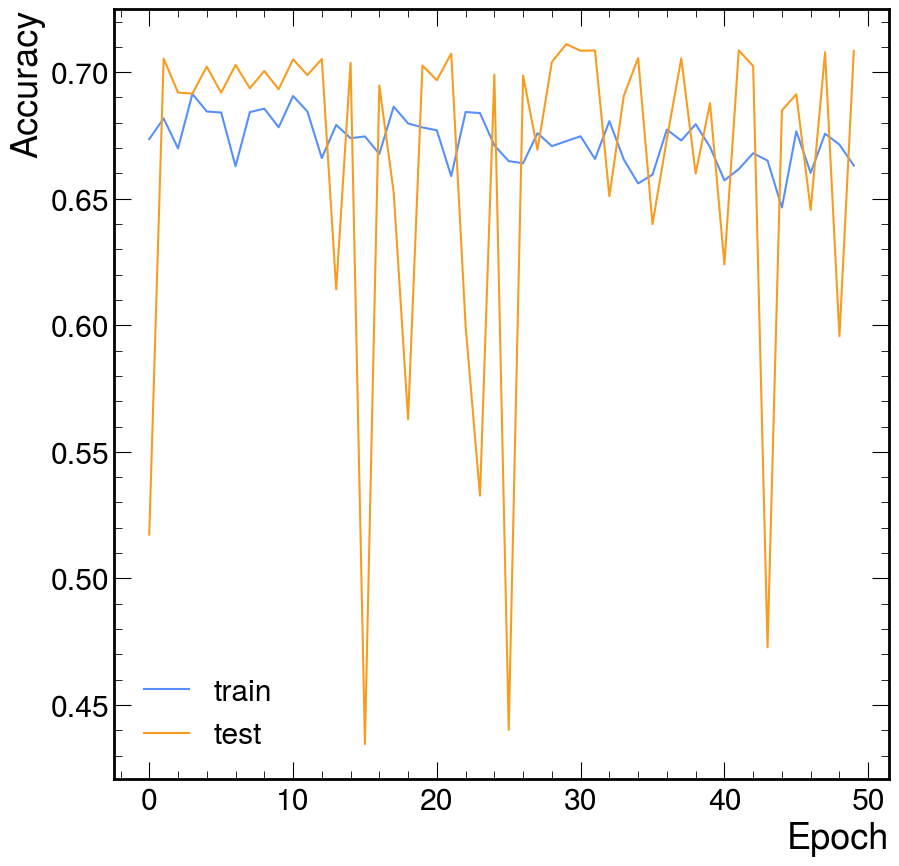

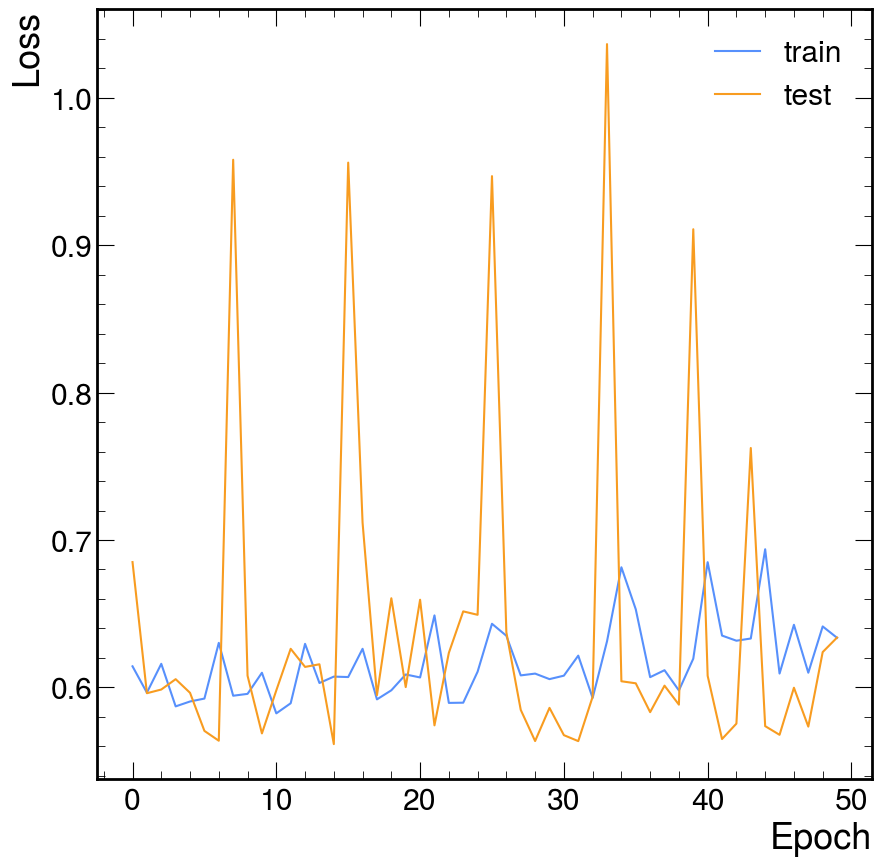

In [107]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=512,
    validation_split=0.2,
    verbose=1,

    #class_weight=class_weights,
)

import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [108]:
# print model scores for wjets and ttbar
wjets_score = model.predict(X_test[y_test==0], verbose=1, batch_size=2048)
ttbar_score = model.predict(X_test[y_test==1], verbose=1, batch_size=2048)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


np.mean(wjets_score): 0.30084407329559326
np.mean(ttbar_score): 0.6254173517227173
[1.] [1.]


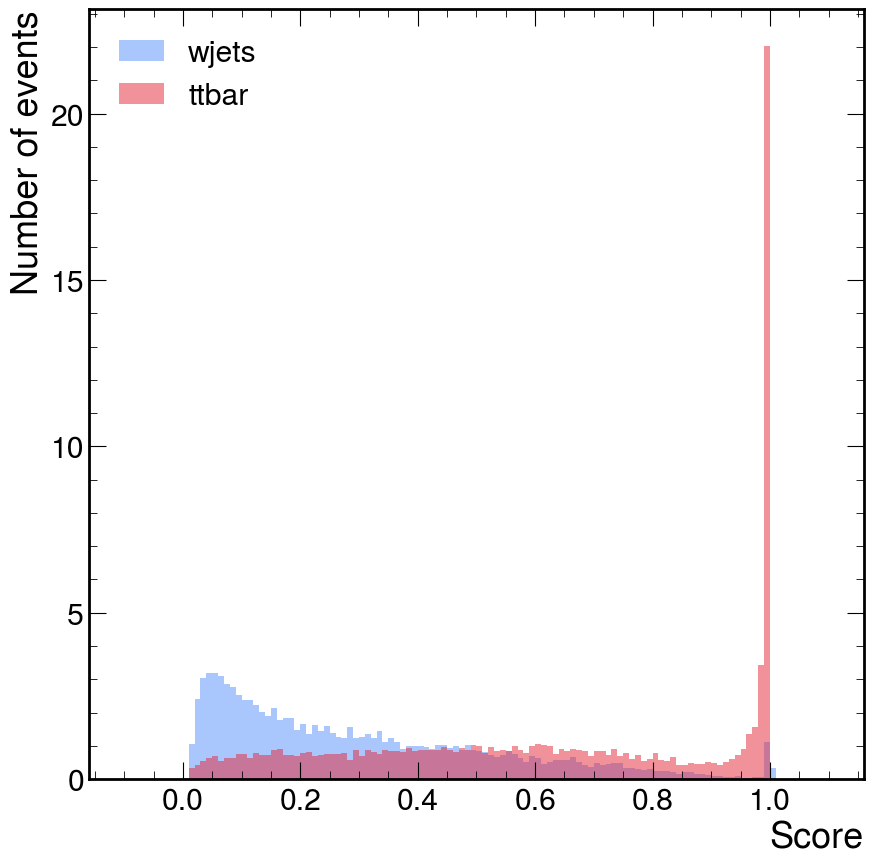

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 16)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,397 (5.46 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 932 (3.64 KB)

13.127598337064278
53.5655737704918


In [109]:
print(f"np.mean(wjets_score): {np.mean(wjets_score)}")
print(f"np.mean(ttbar_score): {np.mean(ttbar_score)}")
print(max(wjets_score), max(ttbar_score))
plt.hist(
    wjets_score,
    bins=np.arange(-0.1, 1.1, 0.01),
    # alpha=0.5,
    #bins=np.arange(0, 1, 0.01),
    label="wjets",
    color=process_color_dict["wjets"],
    alpha=0.5,
    density=True,
)
plt.hist(
    ttbar_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=np.arange(-0.1, 1.1, 0.01),
    label="ttbar",
    color=process_color_dict["ttbar"],
    alpha=0.5,
    density=True,
)
plt.xlabel("Score")
plt.ylabel("Number of events")
plt.legend()
plt.show()

model.summary()

print(len(wjets_score[wjets_score>0.6])/len(wjets_score)*100)
print(len(ttbar_score[ttbar_score>0.6])/len(ttbar_score)*100)

In [86]:
model.save("output/models/model_new_signal.keras")